**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Initialize 

In [ ]:
def get_features_types(data,label) :
    df=data.drop(label,axis=1)
    listoffeatures = str(df.dtypes).split()[1::2][:-1]
    for i in range(len(listoffeatures)):
      if listoffeatures[i] == 'int64' :
          listoffeatures[i] = 'b'
      elif listoffeatures[i] == 'float64' : 
          listoffeatures[i] = 'r'
      elif listoffeatures[i] == 'category':
          listoffeatures[i] = 'c'
    return listoffeatures
 
def get_features_names(data, label) :
  feature=[]
  for col in data.columns :
    feature.append(col)
  feature.remove(label)
  feature.append(label)
  return feature

def get_num_classes(data, label) : 
  DataFrame=data[label].value_counts()
  return len(DataFrame.index)

def get_frequencies(vec, numclasses) : 
  num=vec.size
  val_list=[]
  for i in range(numclasses) :
    val_list.append(np.count_nonzero(vec == i)/num) #this ensure the ordering
  return val_list


def scale_lasso (X_train,y_train,X_test) :
  scaler = StandardScaler()
  scaler.fit(X_train)
  sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear'))
  sel_.fit(scaler.transform(X_train), y_train)
  X_train_selected = sel_.transform(X_train)
  X_test_selected = sel_.transform(X_test)
  return X_train_selected, X_test_selected


Here we import the libraries. 

In [ ]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)
import collections
from itertools import count
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import pickle as cp
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_selection import mutual_info_classif, SelectFromModel
from scipy.stats import chisquare, chi2_contingency, bernoulli

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.linear_model import Ridge, Lasso 

## Naïve Bayes Classifier

You should implement a Naïve Bayes Classifier directly in python. To keep your code tidy,
we recommend implementing it as a class. Make sure that your classifier can handle binary, continuous and categorical features, and an arbitrary number of class labels. Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical, and that there are
4 classes. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'], num_classes=4)

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The fit function is expected to estimate all the parameters ($\theta$ and $\pi$) of the NBC. The predict function is expected to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Before implementing NBC, we suggest you first implement the three types of the distributions of the parameters of NBC. Your implementation should have two functions: **estimate** and **get_probability**. The estimate function takes some data as input and computes the maximum likelihood estimators (MLE) for the parameters $\theta$ of the distribution $p(x | \theta)$. The get_probability function takes a new input value $x_{new}$ and returns $p(x_{new} | \theta)$. For example, in the case of continuous features, we can use the Gaussian distribution. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data, and the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

![alt text](pics/mle_4.png)


You can import statistic libraries for the implementation of the distributions. We recommend using the statistical functions provided by `scipy.stats`. Read the documentation here: https://docs.scipy.org/doc/scipy/reference/stats.html


Let us now implement a class for NBC. We'll keep it simple and try to follow the sklearn models. We'll have an init function, fit function and predict function.

**Hints for function fit**: Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$. 
The fit function will estimate the parameters for NBC based on the training data. 
Here we give you some hints how to estimate the $\theta$ in $p(\mathbf{x} \mid y, \theta)$. 

For each class $c$, we want to estimate the $\theta_c$ for the distribution $p(\mathbf{x} \mid y = c, \theta_c)$. 
Since the assumption of NBC that the features are conditionally independent given the class $c$, the class conditional distribution is a product of $D$ distributions, one for each feature: $p(\mathbf{x} \mid y = c, \theta_c) = \prod_{j}^{D} p(x_j \mid y = c, \theta_{jc})$. Hence, we need to estimate the $\theta_{jc}$ based on the data with class $c$ and feature $j$. 

![alt text](pics/fit_4.png)


**Hints for function predict**: The predict function should compute the probabilities $p(y = c \mid \mathbf{x}_{new}, \pi, \theta)$ for the new inputs $\mathbf{x}_{new}$ on all classes by applying the Bayes rule:

$$p(y = c \mid \mathbf{x}_{new}, \pi, \theta) = \frac{p(y = c \mid \pi_c) \cdot p(\mathbf{x}_{new} \mid y=c, \theta)}{\sum^{C}_{c'=1}p(y=c' \mid \pi_{c'}) \cdot p(\mathbf{x}_{new} \mid y=c', \theta_{c'})},$$

and then return the class that has the largest probability:

$$y_{predict} = \underset{c}{arg\,\max} \, {p(y = c \mid \mathbf{x}_{new}, \theta_c)}.$$

Here we give you some hints on the computation of $p(\mathbf{x}_{new} \mid y=c, \theta_c)$. 
Due to the conditional independence assumption, we have $p(\mathbf{x}_{new} \mid y=c, \theta_c) = \prod_{j}^{D} p(x^j_{new} \mid y = c, \theta_{jc})$. Since we have got the parameters $\theta_{jc}$ in the fit phase,  we can use them to compute the probabilities for the new data. 

![alt text](pics/predict_3.png)

In [ ]:
from math import sqrt
# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        mean=sum(X)/float(len(X))
        stdev=sqrt(sum([(x-mean)**2 for x in X]) / float(len(X)-1))  
        if stdev ==0 : 
          return mean, 10**-6
        else :
          return mean, stdev
   
    def get_probability(self, val):
        # TODO: returns the density value of the input value val
        # Note the input value val could be a vector rather than a single value  
        return ss.norm.pdf(val[0], loc=val[1][0], scale=val[1][1])        

# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X): 
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X           
        param=(sum(X)+1)/float(2+X.shape[0]) #theoratical Laplace smoothing, k=1
        return param

    def get_probability(self, val):
        # TODO: returns the density value of the input value val 
        return ss.bernoulli.pmf(val[0], val[1])

# Distribution for categorical features
class CatFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        n=X.size
        numclasses = len(list(dict.fromkeys(X)))
        val_list=get_frequencies(X, numclasses)
        return n, val_list
            
    def get_probability(self, val):
        # TODO: returns the density value of the input value val
        return ss.multinomial.pmf(val[0], val[1][0], val[1][1])

In [ ]:
class NBC:
    
    
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['r', 'r', 'r', 'r']
    #   num_classes: number of classes of labels
    def __init__(self, feature_types, num_classes):
        self.feature_types = feature_types
        self.num_classes = num_classes 


    # Inputs:
    #   X: X_train
    #   y: Y_train
    def fit(self, X, y): 

      'The function uses the input data to estimate all the parameters of the NBC'

      self.BinFeature=BinFeatureParam()
      self.ContFeature=ContFeatureParam()
      self.CatFeature=CatFeatureParam()   
      self.y_freq=get_frequencies(y, self.num_classes) #𝑝(𝑦=𝑐∣𝜋𝑐)=Nc/N   
      self.all_class_probability=[] #list of dictionnaries for classes

      for i in range(self.num_classes) : 
        indx, = np.where(y != i)
        feature_array = np.delete(X, indx, axis=0)
        
        class_probability={} #support dictionary to collect the classes probability
        for col in range(feature_array.shape[1]) : 
          if self.feature_types[col] == 'b':
              class_probability[col] = self.BinFeature.estimate(feature_array[:,col])
          elif self.feature_types[col] == 'r':  # continuos
              class_probability[col] = self.ContFeature.estimate(feature_array[:,col])
          elif self.feature_types[col] == 'c':  # categorical
              class_probability[col] = self.CatFeature.estimate(feature_array[:,col])
          else :
              print("Error: Unknown feature type")
        self.all_class_probability.append(class_probability) #append to the final parameter list



    # Inputs:
    #   X: X_test
    def predict(self, X):

      'The function takes the data X as input, and predicts the class for the data'
      
      X_test=X

      y_predicted=[]
      for row in range(X_test.shape[0]) : 
        class_probability=[]
        for i in range(self.num_classes) : 
          prob_y=self.y_freq[i] #𝑝(𝑦=𝑐∣𝜋𝑐)
          prob_x=1 #𝑝(𝐱𝑛𝑒𝑤∣𝑦=𝑐,𝜃)
          for col in range(X_test.shape[1]) : 
            val = []
            instance = X_test[row][col]
            param = self.all_class_probability[i].get(col)  
            val.extend((instance, param))

            if self.feature_types[col] == 'b' :
                prob_x = prob_x*self.BinFeature.get_probability(val)
            elif self.feature_types[col] == 'r':
                prob_x = prob_x*self.ContFeature.get_probability(val)
            elif self.feature_types[col] == 'c': 
                prob_x = prob_x*self.CatFeature.get_probability(val) 
          class_probability.append(prob_y*prob_x) #𝑝(𝑦=𝑐∣𝐱𝑛𝑒𝑤,𝜋,𝜃)

        class_probability=class_probability/sum(class_probability)   #∑𝐶𝑐′=1 𝑝(𝑦=𝑐′∣𝜋𝑐′)⋅𝑝(𝐱𝑛𝑒𝑤∣𝑦=𝑐′,𝜃𝑐′)   
        #print(sum(class_probability)) #why greater or smaller than 1???
        index_max = np.argmax(class_probability)
        y_predicted.append(index_max)
        

      return y_predicted 

**Implementation Issues**
-  Fell free to add auxiliary functions. 
- Don't forget to compute $p(y=c | \pi)$ 
- Your implementation should be able to handle missing values
- The variance parameter for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6.
Note that this is essential to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. Also, you want to ensure that the estimates for the parameter for the Bernoulli or Multinoulli random variables
is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
---

- Remember to do all the calculations in log space to avoid running into underflow issues. Read more: (Mur) Chapter 3.5.3
- As far as possible use matrix operations. So assume that Xtrain, ytrain, Xtest will all
be numpy arrays. Try and minimise your use of python loops. (In general, looping over
classes or features is OK, but looping over data is probably not a good idea.)


You can use the below code to do sanity check of your implementation using the iris dataset. All features of the iris dataset are continuous, so you do not need to implement all types of feature parameters to check your code. 

You should expect your implementation has an accuracy larger than 90%. 

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
shuffler = np.random.permutation(N)
Xtrain = X[shuffler[:Ntrain]]
ytrain = y[shuffler[:Ntrain]]
Xtest = X[shuffler[Ntrain:]]
ytest = y[shuffler[Ntrain:]]

nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy)

Accuracy: 0.9666666666666667


## Logistic Regression

For logistic regression, you should use the implementation in sklearn. Adding the following
line will import the LR model.

    from sklearn.linear_model import LogisticRegression

Read the information provided on the following links to understand some details about how the
logistic regression model is implemented in scikit-learn.
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


In [ ]:
from sklearn.linear_model import LogisticRegression

class LR:

    def fit(self, X, y):
      self.clf=LogisticRegression(max_iter=10000000000000).fit(X,y)

    def predict(self, X):
      return self.clf.predict(X)

## Comparing NBC and LR

### Experiments

You will compare the classification error of the NBC and LR trained on increasingly
larger training datasets. Because the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a
function of the size of the training data. Plot these curves for NBC and LR on the datasets.

In [ ]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: training data
#   num_runs=200: we need repeat num_runs times and store average results
#   num_splits=10: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def big_compareNBCvsLR(nbc, lr, X, y, num_runs, num_splits, isLasso):

    'comparaison function for big data set (>400) '

    tst_errs_nbc = np.zeros((num_splits))
    tst_errs_lr = np.zeros((num_splits))
    for runtimes in range(1, num_runs) :  
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
      if isLasso==True : X_train, X_test = scale_lasso(X_train,y_train, X_test)
      if isinstance(y_train,(pd.core.series.Series)):  y_train=y_train.to_numpy()
      if isinstance(y_test,(pd.core.series.Series)):  y_test=y_test.to_numpy()

      for i in range(1,num_splits+1) :        
        train_size = int(X_train.shape[0]*(i/num_splits))
        X_train_used = X_train[:train_size, :]
        y_train_used = y_train[:train_size]
        
        #nbc performance 
        nbc.fit(X_train_used,y_train_used)
        yhat_nbc=nbc.predict(X_test)

        #lr performance 
        lr.fit(X_train_used, y_train_used)
        yhat_lr=lr.predict(X_test)

        #test error
        tst_errs_nbc[i-1] += np.mean(yhat_nbc != y_test)
        tst_errs_lr[i-1] += np.mean(yhat_lr != y_test)


    tst_errs_nbc/=num_runs
    tst_errs_lr/=num_runs

    return tst_errs_nbc, tst_errs_lr

The following function implement the same procedure but for stratified shuffle sampling of small dataset. 

In [ ]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   DataFrame : dataframe for stratified shuffle sampling
#   LabelName, CorrFeatureName : strings for sss
#   num_runs=200: we need repeat num_runs times and store average results
#   num_splits=10: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def small_compareNBCvsLR(nbc, lr, DataFrame, LabelName, CorrFeatureName, num_runs, num_splits, isLasso):

    'comparaison function for small data set '

    tst_errs_nbc = np.zeros((num_splits))
    tst_errs_lr = np.zeros((num_splits))
    for runtimes in range(1, num_runs) :  
      sss = StratifiedShuffleSplit(n_splits=num_splits, test_size=0.2, random_state=None)
      for train_index, test_index in sss.split(DataFrame, DataFrame[CorrFeatureName]):
        DataFrame_train = DataFrame.loc[train_index]
        DataFrame_test = DataFrame.loc[test_index]

      DataFrame_train = DataFrame_train.drop(CorrFeatureName, axis=1)
      DataFrame_test = DataFrame_test.drop(CorrFeatureName, axis=1)

      X_train = DataFrame_train.drop(LabelName, axis=1).to_numpy()
      X_test = DataFrame_test.drop(LabelName, axis=1).to_numpy()
      y_train = DataFrame_train[LabelName].to_numpy()
      y_test = DataFrame_test[LabelName].to_numpy()
      if isLasso==True : X_train, X_test = scale_lasso(X_train,y_train, X_test)

      for i in range(1, num_splits+1) :        
        train_size = int(X_train.shape[0]*(i/num_splits))
        X_train_used = X_train[:train_size, :]
        y_train_used = y_train[:train_size]
        
        
        #nbc performance 
        nbc.fit(X_train_used,y_train_used)
        yhat_nbc=nbc.predict(X_test)

        #lr performance 
        lr.fit(X_train_used, y_train_used)
        yhat_lr=lr.predict(X_test)

        #test error
        tst_errs_nbc[i-1] += np.mean(yhat_nbc != y_test)
        tst_errs_lr[i-1] += np.mean(yhat_lr != y_test)


    tst_errs_nbc/=num_runs
    tst_errs_lr/=num_runs

    return tst_errs_nbc, tst_errs_lr

The utility function below defines the function for plotting. 

In [ ]:
def makePlot(nbc_perf, lr_perf, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * 10 for i in range(10)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

#####**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [ ]:
# TODO: insert your code for experiments
from sklearn.datasets import load_iris
iris_obj = load_iris()
# the code transform the iris dataset to a dataframe
iris = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names,index=pd.Index([i for i in range(iris_obj.data.shape[0])])).join(pd.DataFrame(iris_obj.target, columns=pd.Index(["species"]), index=pd.Index([i for i in range(iris_obj.target.shape[0])])))
#iris.info()
#iris['species'].value_counts()
#iris.describe()

###### Preparation

Spaces in all the features have been replaced with low dashes to fit the function "get_features_types"

In [ ]:
iris=iris.rename(columns={'sepal width (cm)': 'sepal_width(cm)', 'petal width (cm)': 'petal_width(cm)', 'sepal length (cm)': 'sepal_length(cm)', 'petal length (cm)': 'petal_length(cm)'})

There are no missing values and all data type are numerical. To identify the best feature selection's strategy, the Pearson correlation coefficient has been applied. 

In [ ]:
#corr_matrix = iris.corr()
#corr_matrix

To avoid the risk of introducing sampling bias, we set a constraint in the sampling split. Since the feature "petal width (cm)" is the most correlated feature with the label feature, we want to ensure that the test dataset is representative of the various width of petals in the whole dataset. Therefore, we look at the distribution of the "petal width (cm)". In order to include all data points and form categories with more than one entry, we decided to create 9 categories.

In [ ]:
#iris.describe()
#plt.xticks(np.arange(min(iris['petal_width(cm)']), max(iris['petal_width(cm)'])+1, 0.1))
#iris['petal_width(cm)'].hist(bins=10,figsize=(10,10))
iris["petalw_cat"] = pd.cut(iris['petal_width(cm)'], bins=[0,0.35,0.595,1.05,1.30,1.55,1.755,2.005,2.25,2.6], labels=[1,2,3,4,5,6,7,8,9])
#iris["petalw_cat"].hist(figsize=(10,10))

###### Comparaison

Strong correlations between the features "petal length (cm)", "sepal lenght (cm)" and "petal width (cm)" have been remarked. Therefore, feature selection with Lasso will be applied before fitting the classifiers.


In [ ]:
features_types=get_features_types(iris,'species')
num_classes=get_num_classes(iris, 'species')
nbc=NBC(features_types,num_classes)
lr=LR()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


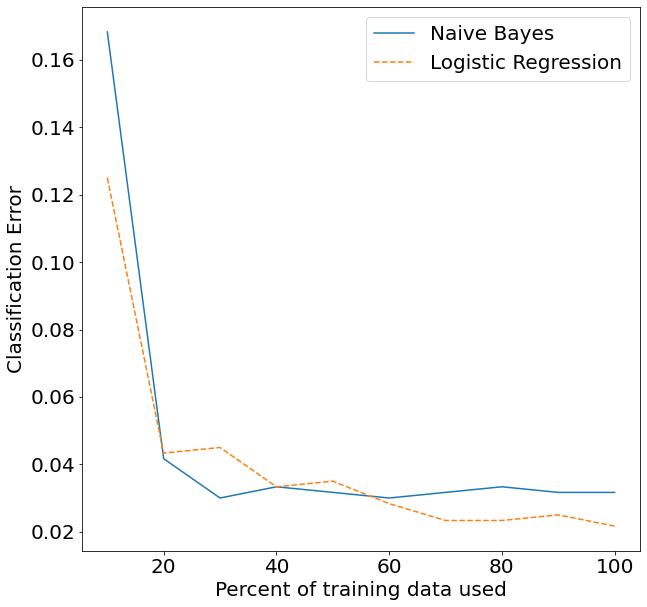

In [ ]:
tst_errs_nbc, tst_errs_lr = small_compareNBCvsLR(nbc, lr, iris, 'species', 'petalw_cat', 20, 10, True)
makePlot(tst_errs_nbc, tst_errs_lr, title=None)

#####**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records


According to a summary of the data frame, all 16 features have at least one missing value and they are all dichotomous categorical variables.

In [ ]:
# TODO: insert your code for experiments
voting = pd.read_csv('voting.csv')
#voting.info()
#voting.head()

For dichotomous categorical variable it is possible to apply Pearson correlation. The goal is to understand which features are the most likely to predict the label.

In [ ]:
#CorrMatrix=voting.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
#CorrMatrix["label"].sort_values(ascending=False)

The correlation of the features "water-project-cost-sharing" and "immigration" with the label are close to zero. Thus, it can be derived that they do not influence significantly the result of the election and they are likely to add noise in the data. Therefore, these features have been dropped.

In [ ]:
voting=voting.drop("water-project-cost-sharing", axis=1)
voting=voting.drop("immigration", axis=1)

Then, the categories has been converted from text to binary (y-->1, n-->0) and the label has been encoded

In [ ]:
voting.replace(('y', 'n'), (1, 0), inplace=True)
labelencoder = LabelEncoder()
voting['label'] = labelencoder.fit_transform(voting['label'])

Even if Naive Bayes can handle missing data, the preparation will be the same for the two classifiers. Otherwise, inputs data X and y will be different for the two classifiers when calling the function "small_compareNBCvsLR".

###### Preparation

The feature "export-administration-act-south-africa" has the highest number of missing entries. Three solutions could be applied to this case : 

1. Drop the rows with missing entries. *This would cause a reduction of around 100 data points (25% of the entier data set).*

2. Drop the feature. *This would remove the possibility of capturing the inverse of the feature which has a correlation of 0.34 with the label (larger than the one in feature 2,10,11)*

3. Fill the missing items with the median. *This might distort the model ability to predict unseen data.*

The smallest of evils seems to be solution 2. Thus, the feature has been dropped.


In [ ]:
voting=voting.drop("export-administration-act-south-africa", axis=1)
#voting.info()

Subsequenty, all data points that have missing values in the first five features with the greatest label correlation have been removed.

In [ ]:
voting=voting.dropna(subset=["physician-fee-freeze"])
voting=voting.dropna(subset=["aid-to-nicaraguan-contras"])
voting=voting.dropna(subset=["adoption-of-the-budget-resolution"])
voting=voting.dropna(subset=["el-salvador-aid"])
voting=voting.dropna(subset=["crime"])
#voting.info()
voting = voting.reset_index(drop=True) #reset the index

Finally, missing values in each feature have been filled with their respective median.

In [ ]:
for i in voting :
    median = voting[i].value_counts().idxmax()
    voting[i].fillna(median, inplace=True)
#voting.info()

######Comparaison

In [ ]:
features_types=get_features_types(voting,'label')
num_classes=get_num_classes(voting, 'label')
nbc=NBC(features_types,num_classes)
lr=LR()

In [ ]:
tst_errs_nbc, tst_errs_lr = big_compareNBCvsLR(nbc, lr, X, y, 200, 10, True)
makePlot(tst_errs_nbc, tst_errs_lr, title=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


ZeroDivisionError: ignored

#####**Dataset 3: Car Evaluation Dataset**

https://archive.ics.uci.edu/ml/datasets/car+evaluation

First, we visualize a summary of the dataframe. From this we discover that all none of the features has missing values.

In [ ]:
# TODO: insert your code for experiments
car = pd.read_csv('car.csv')
#car.info()

Second, we show the first five rows of the data and their object type to understand the nature of each features. We discover that there are a mix of categorical and numerical variables (with upper limits).

In [ ]:
#car.head()

In [ ]:
#car.dtypes

###### Preparation

To encode the data we analyzed three possibilities. 
1. First, an OrdinalEncoder from Sklearn could be deployed. This has the advantage of providing an automatic label for each value of the features, but with the downfall that the number would be usually misleading (e.g. "small" would be equal to one).  
2. The alternative was to manually map the categories. Using the sample code that can be found in this link : https://stackoverflow.com/questions/59065247/how-to-maintain-natural-order-when-label-encoding-with-scikit-learn
3. Finally, it is possible to use a OneHotEncoder and thus losing the natural ordering of the categories.


In [ ]:
for categorical_feature in list(car.columns):
      car[categorical_feature] = car[categorical_feature].astype('category')
#car.dtypes

Here, we used the second technique because we wanted to be sure that the order of the categories was consistent. 

In [ ]:
label_mapping = {"low": 0, "med": 1, "high": 2, "vhigh": 3}
car = car.replace({"buying": label_mapping})
car = car.replace({"maint": label_mapping})
car = car.replace({"safety": label_mapping})

In [ ]:
label_mapping = {"small": 0, "med": 1, "big": 2}
car = car.replace({"lug_boot": label_mapping})
label_mapping = {"unacc": 0, "acc": 1, "good": 3, "vgood": 3}
car = car.replace({"acceptability": label_mapping})

In [ ]:
label_mapping = {"2": 0,"3": 1, "4": 2, "5more": 3}
car = car.replace({"doors": label_mapping})
label_mapping = {"2": 0, "3": 1,"4": 2, "more": 3}
car = car.replace({"persons": label_mapping})
car = car.rename(columns={'doors': 'doors_cat','persons': 'persons_cat'})

In [ ]:
X = car.drop("buying", axis=1)
y = car["buying"]
X_train_car, X_test_car, y_train_car, y_test_car = train_test_split(X, y, test_size=0.2, random_state=42)

###### Comparaison

In [ ]:
for categorical_feature in list(car.columns):
      car[categorical_feature] = car[categorical_feature].astype('category')
#car.dtypes

In [ ]:
features_types=get_features_types(car,'buying')
num_classes=get_num_classes(car, 'buying')
nbc=NBC(features_types,num_classes)
nbc.fit(X_train_car,y_train_car)
Y_predicted=nbc.predict(X_test_car)
test_accuracy = np.mean(Y_predicted == y_test_car)
print("Accuracy:", test_accuracy)

#####**Dataset 4: Breast Cancer Dataset**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

In [ ]:
# TODO: insert your code for experiments
cancer = pd.read_csv('breast-cancer.csv')
#cancer.info()
#cancer.describe()

###### Preparation

Weak correlated features (< 0.1) with the target variable class has been removed .

In [ ]:
#CorrMatrix=cancer.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
#CorrMatrix["Class"].sort_values(ascending=False)
cancer=cancer.drop("menopause", axis=1)
cancer=cancer.drop("breast", axis=1)
cancer=cancer.drop("breast-quad", axis=1)

Afterwards, with the exception of 'deg-malig', the features have been encoded and their data types have been adjusted to fit the get_features_types function. Label encoding has also been performed.

In [ ]:
elist=get_features_names(cancer,'Class')
elist.remove('deg-malig')
for categorical_feature in elist:
      cancer[categorical_feature] = cancer[categorical_feature].astype('category')
      cancer[categorical_feature] = cancer[categorical_feature].cat.codes

cancer['Class'] = cancer['Class'].astype('int64')
cancer['age'] = cancer['age'].astype('category')
cancer['tumor-size'] = cancer['tumor-size'].astype('category')
cancer['inv-nodes'] = cancer['inv-nodes'].astype('category')
cancer['node-caps'] = cancer['node-caps'].astype('int64')
cancer['deg-malig'] = cancer['deg-malig'].astype('category')
cancer['irradiat'] = cancer['irradiat'].astype('int64')

labelencoder = LabelEncoder()
cancer['Class'] = labelencoder.fit_transform(cancer['Class'])

Given that the data is scarce, stratified shuffled sampling has been implemented. 

In [ ]:
#plt.xticks(np.arange(min(cancer['deg-malig']), max(cancer['deg-malig'])+1, 0.1))
#cancer['deg-malig'].hist(bins=10,figsize=(10,10))
cancer["deg-malig-cat"] = pd.cut(cancer['deg-malig'], bins=[0,1.3,2.3,3.1], labels=[1,2,3])

###### Comparaison

In [ ]:
features_types=get_features_types(cancer,'Class')
num_classes=get_num_classes(cancer, 'Class')
nbc=NBC(features_types,num_classes)
lr=LR()

In [ ]:
tst_errs_nbc, tst_errs_lr = small_compareNBCvsLR(nbc, lr, cancer, 'Class', 'deg-malig-cat', 20, 10, False)
makePlot(tst_errs_nbc, tst_errs_lr, title=None)

#####**Dataset 5: Ionosphere Dataset**

https://archive.ics.uci.edu/ml/datasets/ionosphere

In [ ]:
# TODO: insert your code for experiments
ionosphere = pd.read_csv('ionosphere.csv')
#ionosphere.info()
#ionosphere['label'].value_counts()
#ionosphere.head()
#ionosphere.describe()

###### Preparation

Pearson correlation has been employed to describe the relation between variables. "features 2" has been immediately dropped because it is a constant (always equal to 0) which means that it does not influence the target variable. Most of the other features are highly correlated with other features(multicollinearelity). Therefore, similarly with the iris dataset, the Lasso embedded methods has been selected. 

In [ ]:
CorrMatrix=ionosphere.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
#CorrMatrix
#CorrMatrix["label"].sort_values(ascending=False)
#plt.matshow(ionosphere.corr())
#plt.show()
ionosphere=ionosphere.drop("feature2", axis=1)

Finally, the label has been encoded.

In [ ]:
labelencoder = LabelEncoder()
ionosphere['label'] = labelencoder.fit_transform(ionosphere['label'])

######Comparaison

In [ ]:
X = ionosphere.drop("label", axis=1)
y = ionosphere["label"]
features_types=get_features_types(ionosphere,'label')
num_classes=get_num_classes(ionosphere, 'label')
nbc=NBC(features_types,num_classes)
lr=LR()

Feature selection (using Lasso) has been executed while comparing the two classifier. 

In [ ]:
tst_errs_nbc, tst_errs_lr = big_compareNBCvsLR(nbc, lr, X, y, 200, 10, True)
makePlot(tst_errs_nbc, tst_errs_lr, title=None)

#####**Dataset 6: Sonar Dataset**

http://archive.ics.uci.edu/ml/datasets/connectionist+bench+%28sonar,+mines+vs.+rocks%29

In [ ]:
# TODO: insert your code for experiments
sonar = pd.read_csv('sonar.csv')
#sonar.info()
#sonar['label'].value_counts()
#sonar.describe()

###### Preparation

The data does not have any missing values and all features are numerical. A correlation matrix has been constructed to study the features relationships.

In [ ]:
#CorrMatrix=sonar.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
#CorrMatrix
#CorrMatrix["label"].sort_values(ascending=False)
#plt.matshow(sonar.corr())
#plt.show()

###### Comparaison

In [ ]:
X = sonar.drop("label", axis=1)
y = sonar["label"]
features_types=get_features_types(sonar,'label')
num_classes=get_num_classes(sonar, 'label')
nbc=NBC(features_types,num_classes)
lr=LR()

Feature selection (using Lasso) has been executed while comparing the two classifier. 

In [ ]:
tst_errs_nbc, tst_errs_lr = big_compareNBCvsLR(nbc, lr, X, y, 200, 10, True)
makePlot(tst_errs_nbc, tst_errs_lr, title=None)